In [2]:
import numpy as np
from sympy.physics.wigner import wigner_3j
import sympy as sp
from IPython.display import display, Math
import scipy.integrate as integ
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import functions as fn


hbar = 1
me   = 1
mp = 1836.15
u = (me*mp)/(me+mp)
u=1
Z = 2
alfa = 1/137
c = 1/alfa

chi_alf = np.array([1,0])
chi_bet = np.array([0,1])

w,r, phi, theta ,r_ ,phi_,theta_ = sp.symbols('w r phi theta r_ phi_ theta_', real=True)

dtheta = sp.lambdify(theta,sp.sin(theta),"numpy")


hart2cm = 455.633 # en angstroms
hart2ev = 27.2116 # en electronvoltios
hart2invcm = 219475
ua2Tesla = 2.35e5
ua2elV_m = 5.142e11

thetvals,phivals = np.linspace(0.00001,np.pi-0.0001,700) , np.linspace(0.00001,2*np.pi-0.00001,700)
Tvals, Pvals = np.meshgrid(thetvals, phivals) # x, y


"""
Importamos las funciones definidas del anterior taller para asi usar los autoestados del atomo de hidrogeno
"""


def eferic_armonics_numeric(var1,var2,l,m):
    ef = (sp.sqrt((2*l+1)/(4*sp.pi) * sp.factorial(l-abs(m))/sp.factorial(l+abs(m)) )
          * sp.exp(sp.I * m * var2) * 1/(2**l * sp.factorial(l)) *
          (1-w**2)**(abs(m)/2)* sp.diff((w**2-1)**l,(w,l+abs(m))))
    ef = ef.subs(w,sp.cos(var1))
    return ef

def chi(s,ms):
    if ms == 1/2:
        return np.array([1,0])
    elif ms == -1/2:
        return np.array([0,1])

def chi_finder(f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi]
            return chi_bet
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0],
        return chi_alf


def Radial_part_numeric(var1,n,l):
    p = 2*Z*u/n  * var1
    radial = sp.S(0)
    for k in range(n-l):
        radial +=  (-1)**(k+1) * (sp.factorial(n+l))**2/ (sp.factorial(n-l-1-k)*sp.factorial(2*l+1+k)*sp.factorial(k)) * p**k

    radial *= - sp.sqrt(((2*Z*u/n)**3 * sp.factorial(n-l-1)/(2*n*(sp.factorial(n+l))**3  ))) * sp.exp(-p/2) * p**l

    return radial


def integrate_2d(Z, x, y, method):
    """
    Z: 2D array shaped (len(y), len(x))  -> f(y_i, x_j)
    x: 1D array (len Nx)
    y: 1D array (len Ny)
    method: 'rect', 'trapz', or 'simps'
    """
    if method == 'rect':
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        return np.sum(Z) * dx * dy
    elif method == 'trapz':
        return np.trapezoid(np.trapezoid(Z, x=x, axis=1), x=y, axis=0)
    elif method == 'simps':
        return integ.simpson(integ.simpson(Z, x=x, axis=1), x=y, axis=0)
    else:
        raise ValueError("method must be 'rect','trapz' or 'simps'")


def safe_lambdify(vars, expr):
    f = sp.lambdify(vars, expr, "numpy")
    return lambda *args: np.broadcast_to(f(*args), np.broadcast(*args).shape)

def Psi(var1,var2,var3,n,l,ml,s,ms):
    psi = Radial_part_numeric(var1,n,l)*eferic_armonics_numeric(var2,var3,l,ml)*chi(s,ms)
    return psi


def L2_op (f):
    L2 = -hbar**2*(sp.diff(f,theta,2)   +  sp.cot(theta)*sp.diff(f,theta)+1/(sp.sin(theta))**2 *sp.diff(f,phi,2))
    return L2

def R_op(f):
    rop = -hbar**2/(2*u)* (sp.diff(f,r,2) + 2/r * sp.diff(f,r))
    return rop

def Hamiltonian(f):
    Ham = R_op(f) + 1/(2*u*r**2)*L2_op(f) -Z/r * f
    return Ham

def Matx_element_Op (f,op):
    # this finds the matrix element of an specific operator
    r_part = sp.integrate(np.dot(sp.conjugate(f),op)*r**2,(r,0,sp.oo))
    r_part = safe_lambdify((theta,phi), r_part)

    sol = integrate_2d(r_part(Tvals,Pvals)*dtheta(Tvals),thetvals,phivals,'simps')

    sol = float(sol)

    return sol

def quantum_nums(f):

    ml = round(float(Matx_element_Op(f,Lz_op(theta,phi,np.dot(chi_alf+chi_bet,f))*chi_finder(f)  )))

    l_l_1 = float(Matx_element_Op(f,L2_op(np.dot(chi_alf+chi_bet,f))*chi_finder(f)    ))
    l_var = sp.symbols('l_var')
    y = l_var*(l_var+1) - l_l_1
    sol = sp.solve(y,l_var)
    l = round(max(sol))

    En = float(Matx_element_Op(f,Hamiltonian(np.dot(chi_alf+chi_bet,f))*chi_finder(f)   ))
    n = round(math.sqrt(-u*Z**2/(2*En)))

    s = 1/2

    chi = chi_finder(f)
    ms = 0
    if chi[0] == chi_alf[0]:
        ms = 1/2
    elif chi[1] == chi_bet[1]:
        ms = -1/2

    return [n,l,ml,s,ms]



def J2_op (f):
    j2 = L2_op(theta,phi,f) + L2_op(theta_,phi_,f) + 2*(Lx_op(theta,phi,f)+Ly_op(theta,phi,f)+Lz_op(theta,phi,f))* (Lx_op(theta_,phi_,f)+Ly_op(theta_,phi_,f)+Lz_op(theta_,phi_,f))
    return j2

def Jz_op (f):
    jz = Lz_op(theta,phi,f) + Lz_op(theta_,phi_,f)
    return jz


def clebseth_G(j1,j2,m1,m2,j,m,Sp_notSp_):
    if Sp_notSp_ == True:
        return sp.integrate(sp.integrate( np.dot(sp.conjugate(Y_S(j1,m1,j2,m2)) , eferic_armonics_numeric(theta,phi,j,m)* chi_finder(Y_S(j1,m1,j2,m2))  ) * sp.sin(theta),(theta,0,sp.pi)),(phi,0,2*sp.pi))
    else:
        return abs(sp.integrate(sp.integrate( sp.conjugate(Y1_Y2(j1,m1,j2,m2)) * eferic_armonics_numeric(theta,phi,j,m) *sp.sin(theta),(theta,0,sp.pi)),(phi,0,2*sp.pi)))

def Y1_Y2  (l,ml,lp,mp):
    mult_esferic = eferic_armonics_numeric(theta,phi,l,ml) * eferic_armonics_numeric(theta_,phi_,lp,mp)
    return mult_esferic

def Y_S (l,ml,s,ms):
    mult_esferic = eferic_armonics_numeric(theta,phi,l,ml) * chi(s,ms)
    return mult_esferic


def Lx_op (var1,var2,f):
    Lx = 1/2 * (Lplus_op(var1,var2,f)+Lminus_op(var1,var2,f))
    return Lx

def Ly_op (var1,var2,f):
    Ly= 1/(2*sp.I) * (Lplus_op(var1,var2,f)-Lminus_op(var1,var2,f))
    return Ly

def Lz_op (var1,var2,f):
    Lz = -sp.I*hbar*sp.diff(f,var2)
    return Lz

def Lplus_op(var1,var2,f):
    try :
        if float(np.sum(f)) == 0:
            return np.array([0,0])

    except TypeError:
        qnums = quantum_nums(f)
        l_l_1 = float(Matx_element_Op(f,L2_op(np.dot(chi_alf+chi_bet,f))*chi_finder(f)    ))

        if qnums[2] == qnums[1] :
            return np.array([0,0])
        else:
            return hbar* math.sqrt(l_l_1-qnums[2]*(qnums[2]+1)) *Psi(r,var1,var2,qnums[0],qnums[1],qnums[2]+1,qnums[3],qnums[4])

def Lminus_op(var1,var2,f):
    try :
        if float(np.sum(f)) == 0:
            return np.array([0,0])

    except TypeError:
        qnums = quantum_nums(f)
        l_l_1 = float(Matx_element_Op(f,L2_op(np.dot(chi_alf+chi_bet,f))*chi_finder(f)    ))

        if qnums[2] == -qnums[1] :
            return np.array([0,0])
        else:
            return hbar* math.sqrt(l_l_1-qnums[2]*(qnums[2]-1)) *Psi(r,var1,var2,qnums[0],qnums[1],qnums[2]-1,qnums[3],qnums[4])


def Splus_op(f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi]
            return hbar * np.array([f[1],0])
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0], S+ deberia de anular esto.
        return f[0] * np.array([0,0])

def Sminus_op(f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi] , el resultado seria anular
            return f[1] * np.array([0,0])
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0]
        return hbar * np.array([0,f[0]])

def S2_op (f):
    return  3/4 * hbar**2 * f

def Sx_op (f):
    sx = 1/2 * (Splus_op(f)+Sminus_op(f))
    return sx

def Sy_op (f):
    sy = 1/(sp.I*2) * (Splus_op(f)-Sminus_op(f))
    return sy


def Sz_op (f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi]
            return -1/2 * hbar * f
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0],
        return 1/2 * hbar * f


def En1_n2 (n1,n2):
    return -u/2 * Z**2 *(1/n1**2 + 1/n2**2)


# Definimos la matriz spin orbita como :

def SPO(f):

    spo = 1/2 * alfa**2 * Z/r**3 * (  Lz_op(theta,phi,np.dot(chi_alf+chi_bet,Sz_op(f)))*chi_finder(f)   + 1/2*(Lplus_op(theta,phi,Sminus_op(f)) + Lminus_op(theta,phi,Splus_op(f))    ))

    return spo


def make_symmetric(A):
    """
    Given a square matrix A where only the upper-triangular part
    contains meaningful values and the lower-triangular part is zeros,
    return a symmetric matrix.
    """
    A = np.asarray(A)
    return A + A.T - np.diag(np.diag(A))


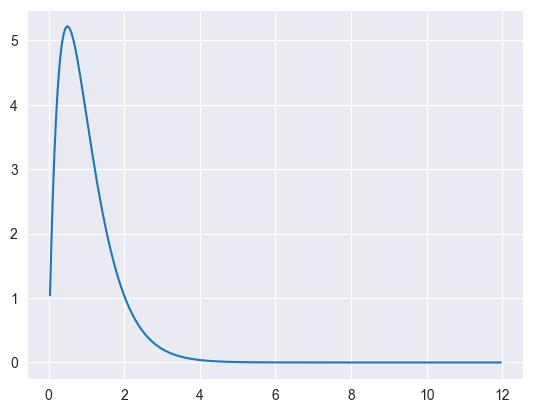

In [3]:
# Parametros de funciones DVR
L = 12
Nf = 301
cycles = 20
R0 = 0
n_R = np.arange(1,Nf+1)

xvals = n_R * L / (Nf +1) + R0

def f(x,n):
    fun_DVR = np.zeros(Nf)
    for k in range(Nf):
        fun_DVR = fun_DVR + (2/math.sqrt(L*(Nf+1)) * np.sin(((k+1)*math.pi*x)/L)*np.sin(((k+1)*n*math.pi)/(Nf+1)))
    return fun_DVR


def DVR_Radial(rvals,n,l):

    Pnl = r * Radial_part_numeric(r,n,l)

    Pnl_num = safe_lambdify(r,Pnl)

    return Pnl_num(rvals)

# Veamos la representación de la función radial del estado fundamental y de estados exitados en esta base

P_r =np.zeros(Nf)

for i in range(1,Nf+1):
    P_r  +=  DVR_Radial(xvals[i-1],1,0) * f(xvals,i)


fig, ax = plt.subplots()

ax.plot(xvals,P_r)





In [5]:

nmax = 10



def Vdir_element (P_coef,n,m):
    V = 0
    for j in range(Nf):
        V += P_coef[0,j]**2 *(1/np.max((xvals[j],xvals[m]))) * fn.dcroc(n,m)
    return V


# Ahora tendremos que usar esta base para hallar la matriz del Hamiltoniano. Para ello aplicamos <fi|H|fj>, que para el caso
# de una particula libre se trata solo de la solucion de la integral de fi*ddfj, la cual ya le tenemos una solucion analitica

def  fiddfj(i,j):
    fiddfj_num = 0
    for k in range(Nf+1):
        fiddfj_num = fiddfj_num - 2*(math.pi)**2/((Nf+1)*L**2) \
                      * (k**2 * np.sin( i*k*math.pi/(Nf+1) )*np.sin(j*k*math.pi/(Nf+1) ) )
    return fiddfj_num


Pcn = np.zeros((nmax,Nf))

for i in range(1,nmax+1):
    for j in range(1,Nf+1):
        Pcn[i-1,j-1] = (math.sqrt(L/(Nf+1))*DVR_Radial(j*L/(Nf+1),i,0))


def HF(P_coef,cycles):

    if cycles > 0:

        P_coef = (P_coef.T / np.linalg.norm(P_coef, axis=1)).T
        VDVR = np.zeros((Nf,Nf))

        # Llenamos el potencial definido para el estado fundamental
        for i in range(Nf):
            VDVR[i,i] = Vdir_element(P_coef,i,i)

        # asi entonces definimos las entradas de nuestra matriz

        # asi entonces definimos las entradas de nuestra matriz

        H1_2 = np.zeros((Nf,Nf))
        fd2f = np.zeros((Nf,Nf))
        Vd = np.zeros((Nf,Nf))

        for l in range(Nf):
            for m in range(l,Nf):
                H1_2[l,m] = - hbar**2/(2*me) * fiddfj(l+1,m+1)
                fd2f[l,m] = - hbar**2/(2*me) * fiddfj(l+1,m+1)
            H1_2[l,l] += -(Z/xvals[l]) + VDVR[l,l]
            Vd[l,l] = -(Z/xvals[l])

        H1_2 = make_symmetric(H1_2)
        fd2f = make_symmetric(fd2f)


        # Aplicamos cambio de base

        H_p = P_coef @ H1_2 @ P_coef.T



        # teniendo el Hamiltiniano, Diagonalizamos para obtener los autovalores

        En, bn = np.linalg.eigh(H_p)

        P_coef = bn.T @ P_coef

        # Cálculo de la energía total
        # - Término E1
        E1 = P_coef[0] @ fd2f @ P_coef[0] + P_coef[0] @ Vd @ P_coef[0]

        ener = 2*E1 + P_coef[0] @ VDVR @ P_coef[0]

        print(f'La energía base hallada para el sistema es: {ener : .8}', "\n")

        cycles -= 1
        HF(P_coef,cycles)
    else:
        return 0

HF(Pcn,cycles)


KeyboardInterrupt: 